In [1]:
# Import stuff
import numpy as np
import matplotlib.pyplot as plt
import sca_training
from Crypto.Cipher import AES
from multiprocessing import Pool
import defs
from functools import partial

# Data preprocessing and visualisation

In [70]:
# Load data
# Produce : traces, plains

# CONFIG : Select dataset
folder = './high-35-10000'
traces = np.load(folder+'/traces.npy')
assert traces.shape[1] == 24400
pairs = np.load(folder+'/pairs.npy')
assert pairs.shape[0] == traces.shape[0]

folder = './high-35'
if False:
    traces2 = np.load(folder+'/traces.npy')
    assert traces2.shape[1] == 24400
    pairs2 = np.load(folder+'/pairs.npy')
    assert pairs2.shape[0] == traces2.shape[0]

    # Use all traces
    traces = np.append(traces,traces2, axis=0)
    pairs = np.append(pairs,pairs2, axis=0)

# Load pairs and filter
mask = np.array([len(p) for p in pairs[:,0]]) == 16
pairs = pairs[mask]
traces = traces[mask]
plains = np.array([list(p) for p in pairs[:,0]])

assert plains.shape[1] == 16
assert plains.shape[0] == traces.shape[0]
print(traces.shape)
print(plains.shape)

(9974, 24400)
(9974, 16)


(9672, 24400)
(9672, 16)
302 traces removed


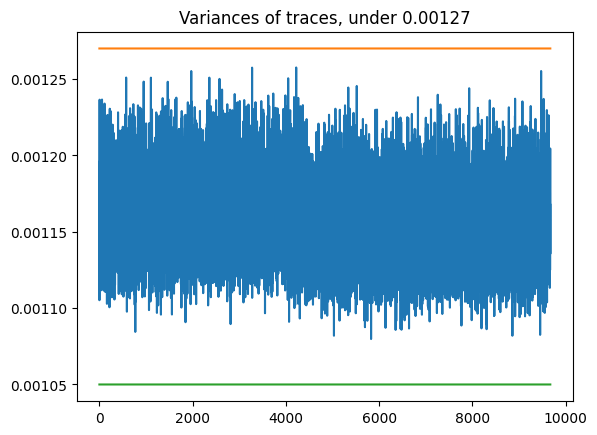

In [75]:
# Clean data
# Uses : traces, plains
# Produces : clean_traces, clean_plains
clean_traces = traces
clean_plains = plains

# CONFIG : Variance's threshold
vars = np.var(clean_traces, axis=1)
threshold = .00127
mask = vars < threshold
clean_traces = clean_traces[mask]
clean_plains = clean_plains[mask]
# Filter min variance
vars = np.var(clean_traces, axis=1)
min_threshold = 0.00105
mask = vars > min_threshold
clean_traces = clean_traces[mask]
clean_plains = clean_plains[mask]

# Visualise variances and corresponding threshold
vars = np.var(clean_traces, axis=1)
plt.plot(vars)
plt.plot([threshold]*len(vars))
plt.plot([min_threshold]*len(vars))
plt.title(f"Variances of traces, under {threshold}")


# Center traces on 0
clean_traces = np.array([p - np.mean(p) for p in clean_traces])

print(clean_traces.shape)
print(clean_plains.shape)
print(f"{traces.shape[0] - clean_traces.shape[0]} traces removed")

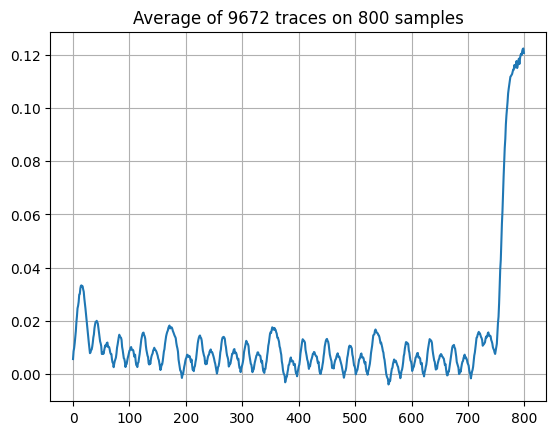

In [80]:
# Frame samples and traces, then visualise
# Uses : clean_traces, clean_plains
# Produces : framed_traces, framed_plains
framed_traces = clean_traces
framed_plains = clean_plains

# CONFIG : Frame samples
# All : 100 - None
# First round : 950 - 1750 (Bourrelet avant le grand pic)
# Second round : 3725 - 4450
start = 3700
end = 4500 # None for all

if end is None:
    end = framed_traces.shape[1]
framed_traces = framed_traces[:,start:end]

# CONFIG : Frame traces
start = 0
end = None # None for all

if end is None:
    end = framed_traces.shape[0]
framed_traces = framed_traces[start:end]
framed_plains = framed_plains[start:end]

plt.grid()
plt.title(f"Average of {framed_traces.shape[0]} traces on {framed_traces.shape[1]} samples")
_ = plt.plot(np.mean(framed_traces, axis=0))

# Correlation with traces

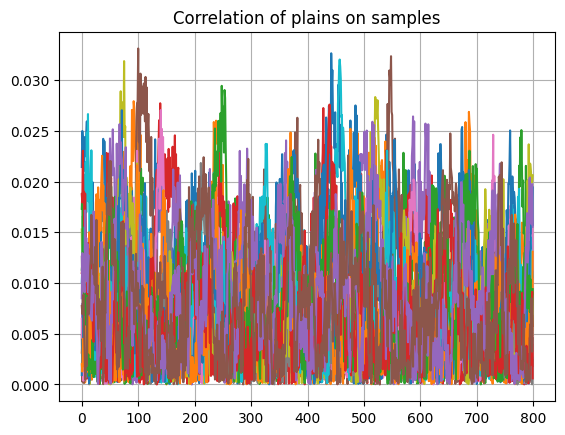

In [54]:
# OPT
# Uses : framed_plains, framed_traces

tt = framed_traces.T
pts = framed_plains.T
pts = np.array([sca_training.HW_uint8[pt] for pt in pts])
corrs = np.array([defs.matrix_corrcoef(tt, pt) for pt in pts])

plt.title("Correlation of plains on samples")
plt.grid()
_ = [plt.plot(corr) for corr in corrs]

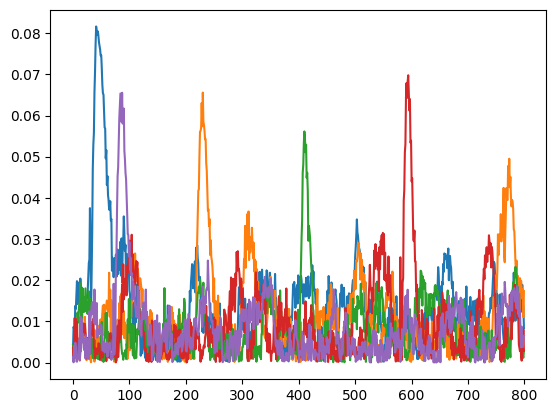

In [77]:
# OPT
# Correlate some key guess with samples (HEIG{ and SCA{)
cands = [
    (0, 'H'),
    (1, 'E'),
    (2, 'I'),
    (3, 'G'),
    (4, '{'),
]

tt = framed_traces.T
pt = framed_plains.T

corrs = []
for cand in cands:
    cand = sca_training.HW_uint8[sca_training.Sbox[np.bitwise_xor(pt[cand[0]], ord(cand[1]))]] # First round
    corrs.append(defs.matrix_corrcoef(tt, cand))

_ = [plt.plot(p) for p in corrs]

# Attack on first 16

In [78]:
# Attack
threshold = 1
target_bytes = []

#candidates = range(32,127)
candidates = [ord(c) for c in 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz']
idx = range(5,16)
k10_max = [0]*16
corrs_max = [[] for _ in range(16)]

k10_max[0] = ord('H')
k10_max[1] = ord('E')
k10_max[2] = ord('I')
k10_max[3] = ord('G')
k10_max[4] = ord('{')

tt = framed_traces.T
pt = framed_plains.T

with Pool(len(idx)) as pool:
    results = pool.map(partial(defs.attack_byte, candidates, pt, tt, threshold), idx)

for (i, j) in enumerate(idx):
    k10_max[j] = results[i][0]
    corrs_max[j] = results[i][1]

print("done")

done


HEIG{OnlyForTheH


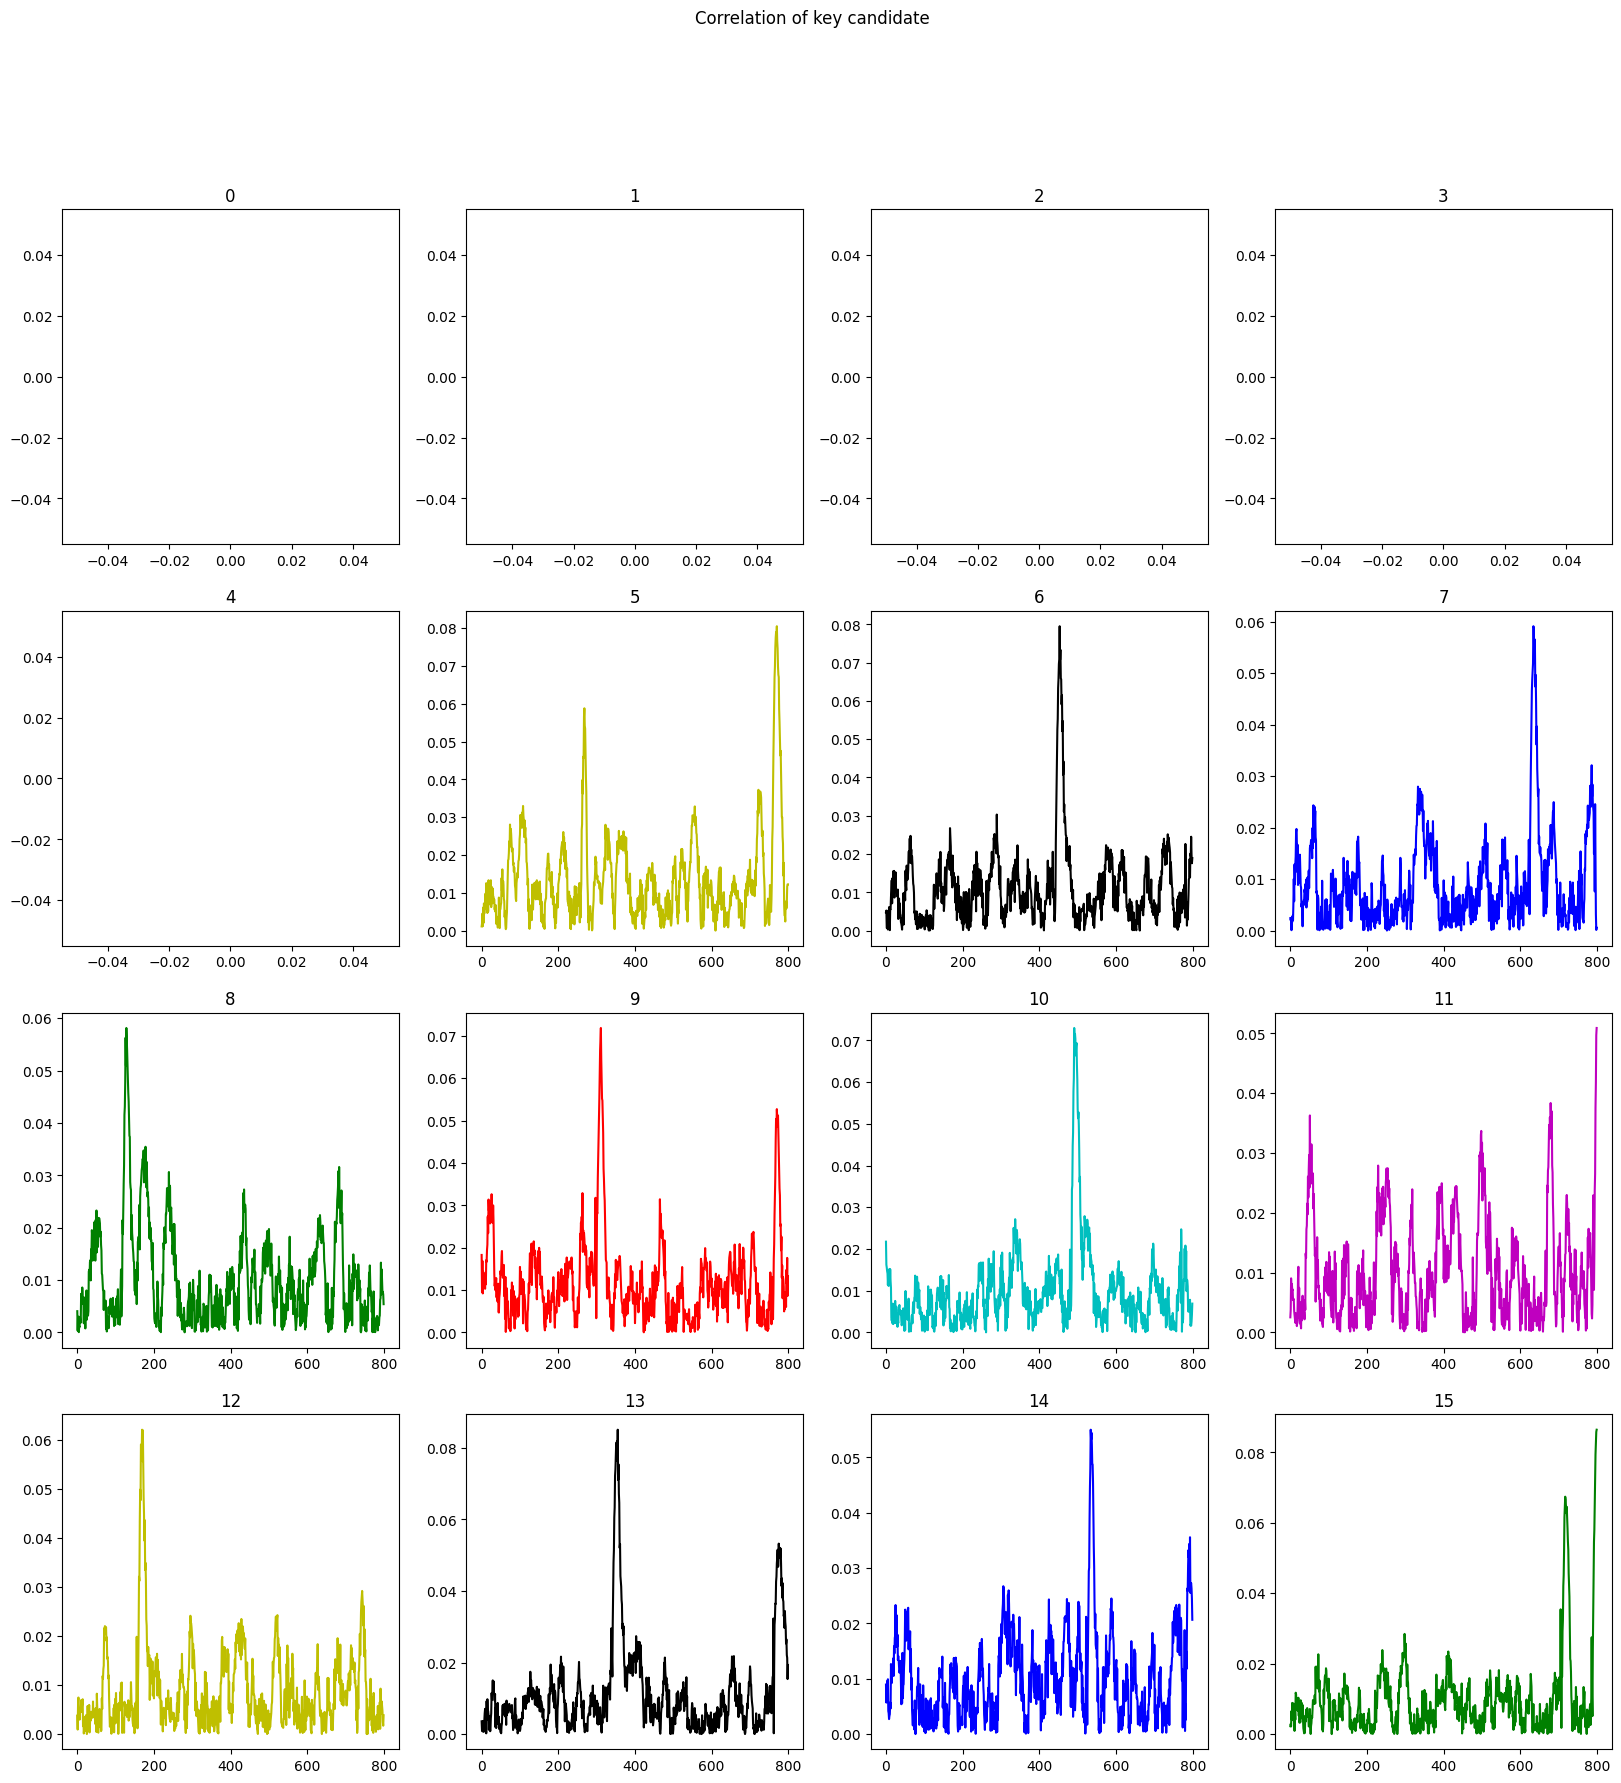

In [79]:
# Visualisation of attack on first 16
k = k10_max
flag = ''.join(chr(c) for c in k)
print(flag)
# "HEIG{OnlyForTheH" ? Me paraît safe

# Correlation visualisation
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
fig.suptitle("Correlation of key candidate")
i = 0
for x in ax:
    for y in x:
        y.set_title(i)
        y.plot(corrs_max[i],color=colors[i%7])
        i += 1

# Attack on last 16

In [81]:
# Uses : framed_plains
# Produces : state1
# Prepare plains
from copy import copy

first_key = [ord(c) for c in 'HEIG{OnlyForTheH']

def first_round(plain, k):
    xor = np.bitwise_xor(plain, k)
    sbox = sca_training.Sbox[xor]
    srows = sca_training.shift_rows(sbox)
    final = defs.mixcol(srows)
    return final

#plains = MixColumns(ShiftRows(Sbox(plains ^ k)))
print(framed_plains.shape)
state1 = np.array([first_round(p, first_key) for p in framed_plains])
print(state1.shape)

(9672, 16)
(9672, 16)


In [82]:
# Attack
# Et à partir de là, j'ai de nouveau des "plains" (une state) et des traces à corréler, exactement comme avant
# Mais là, on va récupérer la K de fin de round 1 en espérant qu'elle contienne des infos sur la "masterkey"

# Selon ma théorie de 01:13 du matin, la keyexp fait une matrice 4 par 8 (donc les 16 premiers octets en 4x4 puis la fin en 4x4 de la master) et ensuite étend cette matrice pour la suite. Donc le AddRoundKey de fin de round 1 c'est les 16 derniers octets de la clé sans aucune transformation ! Enfin, Insch'Allah

# CONFIG
threshold = 1
all_bytes = True
target_bytes = []

# Attack parameters
#candidates = range(32,127)
#candidates = range(256)
candidates = [ord(c) for c in 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789}!']
idx = range(15)

# Storage
k2 = [0]*16
corrs_max = [[] for _ in range(16)]

# Key guess
k2[-1] = ord('}')

# True attack
tt = framed_traces.T
pt = state1.T

with Pool(len(idx)) as pool:
    results = pool.map(partial(defs.attack_byte, candidates, pt, tt, threshold), idx)

for (i, j) in enumerate(idx):
    k2[j] = results[i][0]
    corrs_max[j] = results[i][1]

print("done")

done


ardc0rePlayers!}
HEIG{OnlyForTheHardc0rePlayers!}


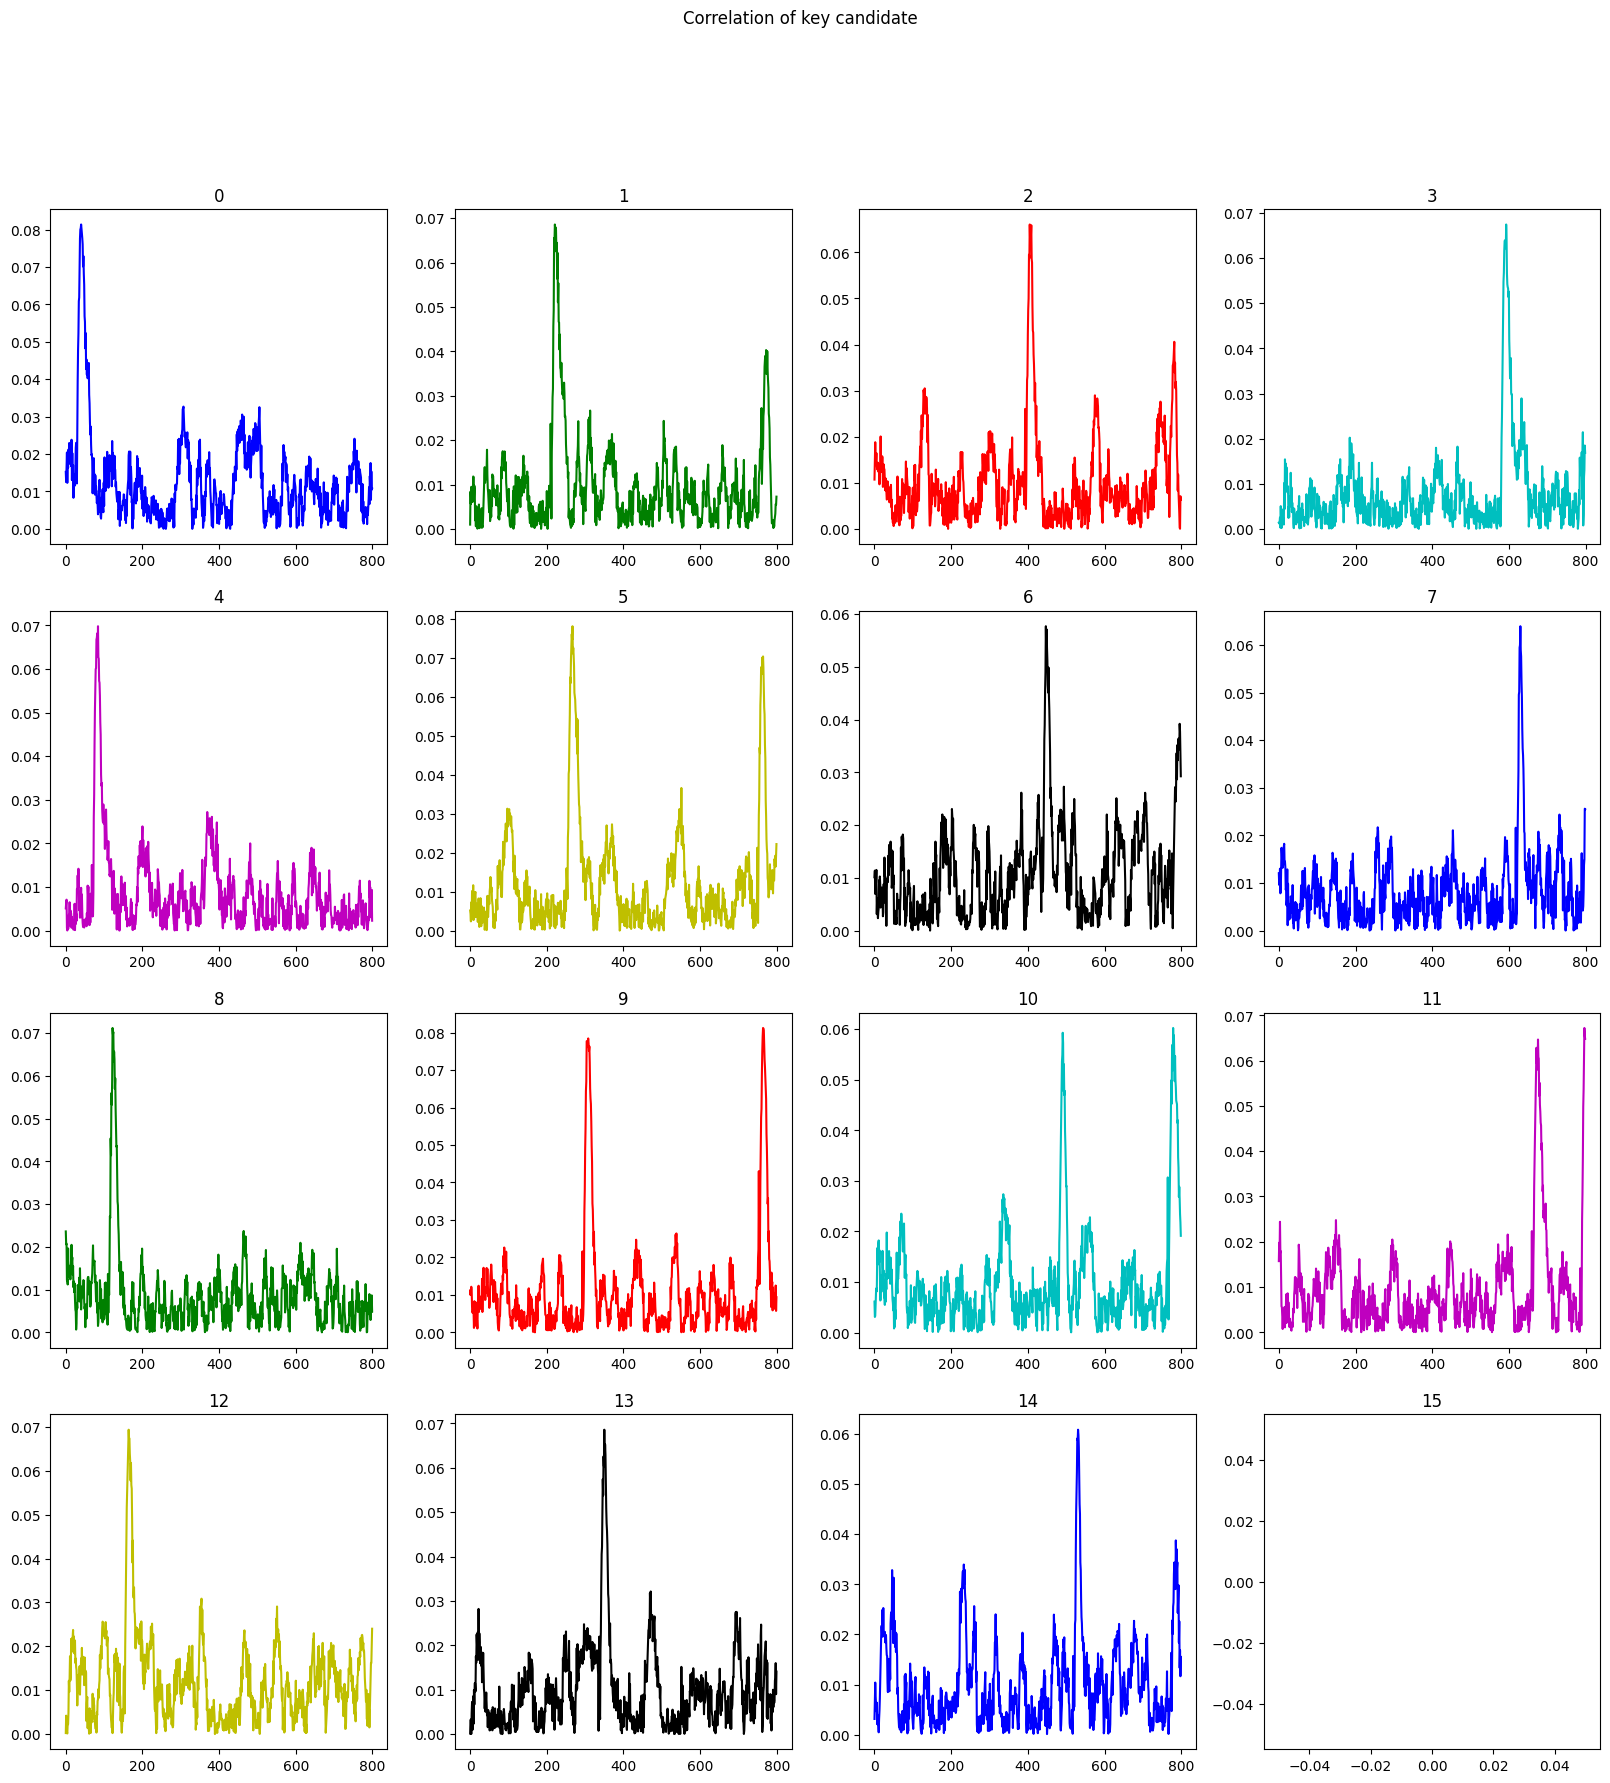

In [83]:
# Visualisation of attack on first 16
k = k2
flag = ''.join(chr(c) for c in k)
print(flag)
print(''.join(map(chr, first_key))+flag)
# Almost : HEIG{OnlyForTheHardcbrePlayersD}
# Guess  : HEIG{OnlyForTheHardcorePlayers!}
# Flag   : HEIG{OnlyForTheHardc0rePlayers!}

# Correlation visualisation
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
fig.suptitle("Correlation of key candidate")
i = 0
for x in ax:
    for y in x:
        y.set_title(i)
        y.plot(corrs_max[i],color=colors[i%7])
        i += 1

In [114]:
key = bytearray(k10_max + k2)
p = pairs[0][0]
check = pairs[0][1]

aes = AES.new(key, AES.MODE_ECB)
c = aes.encrypt(p)

assert c == check, 'Not the good key sorry'